# Run Models

In [4]:
# Import Libraries
%run /Users/u4eeevmq/Documents/Python/HyporheicFloPy/VQuintana/common_imports.py

# Retrieve stored variables
%store -r md6_exe_path
%store -r md7_exe_path
%store -r sim_name
%store -r workspace
%store -r figs_path
%store -r gwf_name
%store -r mp7_name
%store -r gwf_ws
%store -r mp7_ws
%store -r headfile
%store -r head_filerecord
%store -r budgetfile
%store -r budget_filerecord
%store -r write
%store -r run
%store -r plot
%store -r plot_show
%store -r plot_save

# Retrieve model parameters
%store -r length_units
%store -r time_units
%store -r nper
%store -r cell_size_x
%store -r cell_size_y
%store -r gw_mod_depth
%store -r z
%store -r kh
%store -r kv
%store -r gw_offset
%store -r porosity
%store -r rch_iface
%store -r rch_iflowface
%store -r recharge_rate
%store -r nstp
%store -r perlen
%store -r tsmult

# Retrieve spatial data
%store -r hec_ras_crs
%store -r terrain_elevation
%store -r raster_transform
%store -r transform
%store -r raster_crs
%store -r output_raster
%store -r cropped_output_raster
%store -r ground_water_domain
%store -r left_boundary
%store -r right_boundary

# retrieve model domain data
%store -r terrain_elevation
%store -r raster_transform
%store -r raster_crs
%store -r raster_bounds_box
%store -r bed_elevation
%store -r raster_width
%store -r raster_height
%store -r ncol
%store -r nrow
%store -r top
%store -r nlay
%store -r grid_x
%store -r grid_y
%store -r grid_points
%store -r intersecting_points
%store -r xorigin
%store -r yorigin
%store -r xmin
%store -r ymin
%store -r xmax
%store -r ymax
%store -r tops
%store -r botm

# retrieve model boundary data
%store -r left_start
%store -r left_end
%store -r right_start
%store -r right_end
%store -r upstream_start_x
%store -r upstream_start_y
%store -r upstream_end_x
%store -r upstream_end_y
%store -r downstream_start_x
%store -r downstream_start_y
%store -r downstream_end_x
%store -r downstream_end_y
%store -r upstream_line
%store -r downstream_line
%store -r upstream_boundary
%store -r downstream_boundary
%store -r grid_cells
%store -r grid_gdf
%store -r idomain

# retrieve model boundary conditions
%store -r boundary_cells
%store -r left_boundary_cells
%store -r right_boundary_cells
%store -r upstream_boundary_cells
%store -r downstream_boundary_cells
%store -r all_boundary_cells
%store -r unique_boundary_cells
%store -r left_boundary_cells_first_layer
%store -r right_boundary_cells_first_layer
%store -r upstream_boundary_cells_first_layer
%store -r downstream_boundary_cells_first_layer
%store -r max_elevation_upstream
%store -r max_elevation_downstream
%store -r gw_elevation_left_first
%store -r gw_elevation_left_last
%store -r gw_elevation_right_first
%store -r gw_elevation_right_last
%store -r gw_elevation_upstream_first
%store -r gw_elevation_upstream_last
%store -r gw_elevation_downstream_first
%store -r gw_elevation_downstream_last
%store -r gw_elevation_left
%store -r gw_elevation_right
%store -r gw_elevation_upstream
%store -r gw_elevation_downstream
%store -r grid_points_coords
%store -r elevation_values
%store -r grid_points_df
%store -r output_csv
%store -r cropped_df
%store -r river_cells
%store -r river_x
%store -r river_y
%store -r river_elevation
%store -r chd_data
%store -r unique_chd_cells
%store -r duplicate_chd_cells
%store -r chd_data_converted

# retrieve well data
%store -r wel_data

# retrieve nodes
# %store -r nodes


## MODFLOW 6 Groundwater Model

In [5]:
#----------------------Model Setup Functions ------------------------#
def build_gwf_model(example_name):
    print(f"Building GWF model for {example_name}")

    # Instantiate the MODFLOW 6 GWF simulation object
    gwfsim = flopy.mf6.MFSimulation(
        sim_name=gwf_name, exe_name=md6_exe_path, sim_ws=gwf_ws
    )

    # Instantiate the MODFLOW 6 temporal discretization package
    flopy.mf6.modflow.mftdis.ModflowTdis(
        gwfsim,
        pname="tdis",
        time_units="DAYS",
        nper=nper,
        perioddata=[(perlen, nstp, tsmult)],
    )

    # Instantiate the MODFLOW 6 gwf (groundwater-flow) model
    gwf = flopy.mf6.ModflowGwf(
        gwfsim, modelname=gwf_name, model_nam_file=f"{gwf_name}.nam", save_flows=True
    )

    # Instantiate the MODFLOW 6 gwf discretization package
    flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        gwf,
        nlay=len(botm),  # Number of layers (based on `botm` list length)
        nrow=nrow,       # Number of rows in the grid
        ncol=ncol,       # Number of columns in the grid
        delr=cell_size_x,  # Cell width
        delc=cell_size_y,  # Cell height
        top=tops[0],       # List of dynamically calculated top elevation of the first layer
        botm=botm,          # List of bottom elevations for all layers
        idomain=idomain,    # List of dynamically calculated active and inactive cells in the model domain
        xorigin=xorigin,  # Assign dynamically calculated xorigin
        yorigin=yorigin   # Assign dynamically calculated yorigin
    )
    
    # Add initial conditions (IC package)
    strt_array = np.full((len(botm), nrow, ncol), bed_elevation)

    # Instantiate the MODFLOW 6 gwf initial conditions package
    flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=strt_array)
    
    # Instantiate the MODFLOW 6 gwf node property flow package
    flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
        gwf,
        pname="npf",
        icelltype=2,
        k=kh,
        k33=kv,
        save_flows=True,
        save_saturation=True,
        save_specific_discharge=True,
    )

    # Create an iterative model solution (IMS) for the MODFLOW 6 gwf model
    flopy.mf6.ModflowIms(
        gwfsim,
        print_option="SUMMARY",
        outer_dvclose=1e-4,  # Increase convergence criteria for outer iterations
        outer_maximum=200,  # Increase maximum number of outer iterations
        under_relaxation="NONE",
        inner_maximum=500,  # Increase maximum number of inner iterations
        inner_dvclose=1e-4,  # Increase convergence criteria for inner iterations
        rcloserecord=1e-4,  # Increase residual convergence criteria
        linear_acceleration="BICGSTAB",  # Switch to Bi-Conjugate Gradient Stabilized method
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=0.97,  # Adjust relaxation factor
    )

    # Assign CHD Package to the model if there are valid unique boundary cells
    if not chd_data_converted:
        print("❌ No CHD boundary cells assigned. Please check the input data and conditions.")
    else:
        # Format the CHD values to ensure they are not in scientific notation
        formatted_chd_data = [
            [item[0], item[1], item[2], float(f"{item[3]:.2f}")]
            for item in chd_data_converted
        ]
    
        # Assuming 'gwf' is your groundwater flow model instance
        flopy.mf6.ModflowGwfchd(
            gwf,
            maxbound=len(formatted_chd_data),  # Set to actual assigned CHD cells
            stress_period_data={0: formatted_chd_data},  # Apply the boundary conditions in stress period 0
            pname="CHD",
            save_flows=True,
            filename=f"{gwf_name}.chd"
        )

    print(f"✅ Assigned {len(formatted_chd_data)} unique CHD boundary cells.")

    # Instantiate the MODFLOW 6 prt output control package
    saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
    printrecord = [("HEAD", "LAST")]
    flopy.mf6.ModflowGwfoc(
        gwf,
        saverecord=saverecord,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        printrecord=printrecord,
    )
    return gwfsim, gwf

## MODPATH 7 Particle Tracking

In [6]:
def build_particle_models(example_name, gwf):
    print(f"Building MODPATH 7 model for {example_name}")

    # Define the MODPATH 7 model name and workspace
    mpnamf = f"{example_name}_mp_forward"

    # Create the MODPATH 7 forward tracking simulation
    mp = flopy.modpath.Modpath7.create_mp7(
        modelname=mp7_name,
        trackdir="forward",
        flowmodel=gwf,
        model_ws=str(mp7_ws),
        rowcelldivisions=1,
        columncelldivisions=1,
        layercelldivisions=1,
        exe_name=md7_exe_path,
    )

    # Write MODPATH 7 input files
    mp.write_input()

    return mp

## Simulation Settings

In [7]:
def write_models(*sims, silent=False):
    for sim in sims:
        if isinstance(sim, flopy.mf6.MFSimulation):
            sim.write_simulation(silent=silent)
        else:
            sim.write_input()

@timed
def run_models(*sims, silent=False):
    for sim in sims:
        if isinstance(sim, flopy.mf6.MFSimulation):
            print(f"Running simulation: {sim.name}")
            success, buff = sim.run_simulation(silent=silent, report=True)
        else:
            print(f"Running model: {sim.name}")
            success, buff = sim.run_model(silent=silent, report=True)
        
        if not success:
            print(f"Simulation {sim.name} failed.")
            print(buff)
            break
        else:
            print(f"Simulation {sim.name} succeeded.")

In [8]:
## Plot Groundwater Model Results

In [9]:
def load_head():
    # Assuming you have a head file to load
    head_file = gwf_ws / headfile
    head_obj = flopy.utils.HeadFile(head_file)
    head = head_obj.get_data()
    return head

def plot_gwf_all(gwfsim):
    # get gwf model
    gwf = gwfsim.get_model(gwf_name)
    head = load_head()

    # Load the discretization file to access model grid information
    dis = gwf.get_package("DIS")
    nlay, nrow, ncol = dis.nlay.data, dis.nrow.data, dis.ncol.data

    # Load the idomain array to identify active cells
    idomain = dis.idomain.array # No results will be visible otherwise

    # Choose the layer you want to plot, e.g., the first layer (layer 0)
    layer_to_plot = 1  # You can change this to any other layer (0-based index)

    # Extract the groundwater head for the specified layer (nrow, ncol)
    head_layer = head[layer_to_plot, :, :]

    # Mask the inactive cells in the head_layer array
    head_layer_masked = np.ma.masked_where(idomain[layer_to_plot, :, :] == 0, head_layer)

    # Plot the groundwater head for the chosen layer
    plt.figure(figsize=(10, 6))
    plt.imshow(head_layer_masked, cmap='viridis', origin='lower', extent=[0, ncol, 0, nrow])
    plt.colorbar(label='Groundwater Head (m)')
    plt.title(f'Groundwater Head at Layer {layer_to_plot + 1}')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()

    # Load the surface elevation data
    surface_elevation = dis.top.array

    # Choose the layers you want to plot, e.g., the first layer (layer 0) and the last layer
    layer_to_plot_first = 0  # First layer (0-based index)
    layer_to_plot_last = nlay - 1  # Last layer (0-based index)

    # Extract the groundwater head for the specified layers (nrow, ncol)
    head_layer_first = head[layer_to_plot_first, :, :]
    head_layer_last = head[layer_to_plot_last, :, :]

    # Mask the inactive cells in the head_layer arrays
    head_layer_first_masked = np.ma.masked_where(idomain[layer_to_plot_first, :, :] == 0, head_layer_first)
    head_layer_last_masked = np.ma.masked_where(idomain[layer_to_plot_last, :, :] == 0, head_layer_last)

    # Plot the surface elevation for active cells and overlay groundwater head contours
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Plot for the first layer
    top_active_first = np.ma.masked_where(idomain[layer_to_plot_first, :, :] == 0, surface_elevation)
    im1 = axs[0].imshow(top_active_first, cmap="terrain", interpolation="nearest", origin="lower",
                        extent=[0, ncol, 0, nrow], alpha=0.7)
    plt.colorbar(im1, ax=axs[0], label='Surface Elevation (m)')

    # Check if the minimum and maximum values are different before creating contour levels
    if head_layer_first_masked.min() != head_layer_first_masked.max():
        contour_first = axs[0].contour(head_layer_first_masked, levels=np.linspace(head_layer_first_masked.min(), head_layer_first_masked.max(), 10), colors='blue', extent=[0, ncol, 0, nrow])
        axs[0].clabel(contour_first, inline=True, fontsize=8, fmt='%1.1f')
    axs[0].set_title(f'Surface Elevation and Groundwater Head Contours at Layer {layer_to_plot_first + 1}')
    axs[0].set_xlabel('Column')
    axs[0].set_ylabel('Row')

    # Plot for the last layer
    top_active_last = np.ma.masked_where(idomain[layer_to_plot_last, :, :] == 0, surface_elevation)
    im2 = axs[1].imshow(top_active_last, cmap="terrain", interpolation="nearest", origin="lower",
                        extent=[0, ncol, 0, nrow], alpha=0.7)
    plt.colorbar(im2, ax=axs[1], label='Surface Elevation (m)')

    # Check if the minimum and maximum values are different before creating contour levels
    if head_layer_last_masked.min() != head_layer_last_masked.max():
        contour_last = axs[1].contour(head_layer_last_masked, levels=np.linspace(head_layer_last_masked.min(), head_layer_last_masked.max(), 10), colors='blue', extent=[0, ncol, 0, nrow])
        axs[1].clabel(contour_last, inline=True, fontsize=8, fmt='%1.1f')
    axs[1].set_title(f'Surface Elevation and Groundwater Head Contours at Layer {layer_to_plot_last + 1}')
    axs[1].set_xlabel('Column')
    axs[1].set_ylabel('Row')

    plt.tight_layout()
    plt.show()

    #---------------------- Zoom In to idomain ------------------------#
    # Choose the layers you want to plot
    layers_to_plot = [1, 19, 39]  # 1st, 20th, and 40th layers (0-based index)

    # Extract the groundwater head for the specified layers (nrow, ncol)
    head_layers = [head[layer, :, :] for layer in layers_to_plot]

    # Mask the inactive cells in the head_layer arrays
    head_layers_masked = [np.ma.masked_where(idomain[layer, :, :] == 0, head_layers[i]) for i, layer in enumerate(layers_to_plot)]

    # Determine the extent of the active cells
    active_cells = np.any(idomain, axis=0)
    active_rows, active_cols = np.where(active_cells)
    row_min, row_max = active_rows.min(), active_rows.max()
    col_min, col_max = active_cols.min(), active_cols.max()

    # Define the extent for the plots
    extent = [col_min, col_max + 1, row_min, row_max + 1]

    # Plot the surface elevation for active cells and overlay groundwater head contours
    fig, axs = plt.subplots(3, 1, figsize=(10, 30))

    for i, layer in enumerate(layers_to_plot):
        # Plot for each layer
        top_active = np.ma.masked_where(idomain[layer, :, :] == 0, surface_elevation)
        im = axs[i].imshow(top_active[row_min:row_max+1, col_min:col_max+1], cmap="terrain", interpolation="nearest", origin="lower",
                           extent=extent, alpha=0.7)
        plt.colorbar(im, ax=axs[i], label='Surface Elevation (m)')
        contour = axs[i].contour(head_layers_masked[i][row_min:row_max+1, col_min:col_max+1], levels=np.linspace(head_layers_masked[i].min(), head_layers_masked[i].max(), 10), colors='blue', extent=extent)
        axs[i].clabel(contour, inline=True, fontsize=8, fmt='%1.1f')
        axs[i].set_title(f'Surface Elevation and Groundwater Head Contours at Layer {layer + 1}')
        axs[i].set_xlabel('Column')
        axs[i].set_ylabel('Row')

    plt.tight_layout()
    plt.show()

    #---------------------- 3D Plot of the Model ------------------------#
    top = dis.top.array
    botm = dis.botm.array
    idomain = dis.idomain.array  # Assuming idomain is part of the dis object

    # Combine top and botm to get the elevation data for all layers
    elevation_data = np.concatenate(([top], botm), axis=0)

    # Get the number of rows and columns
    nrows, ncols = top.shape

    # Layer to plot for terrain
    terrain_layer = 0

    # Create a meshgrid for x and y coordinates
    x = np.linspace(0, ncols - 1, ncols)
    y = np.linspace(0, nrows - 1, nrows)
    x, y = np.meshgrid(x, y)

    # Mask the elevation data using the idomain array
    #z = np.ma.masked_where(idomain[terrain_layer, :, :] == 0, elevation_data[terrain_layer, :, :])

    # Set up plot
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

    # Light source for hillshading
    ls = LightSource(270, 45)

    # Plot the masked elevation data
    z = elevation_data[terrain_layer, :, :]
    rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                        linewidth=0, antialiased=False, shade=False)

    # Set plot labels and title
    ax.set_title('3D Terrain Elevation')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_zlabel('Elevation (ft)')

    plt.show()

## Code from:
# https://github.com/matplotlib/matplotlib/tree/cfe5bf75eaf378b9523830908036f2123acfe4e7/examples/frontpage/3D.py

## Plot Particle Tracking Results

In [ ]:
def plot_modpath7_results(mpnamf, ws, gwf, nlay=1, max_particles=None):
    """
    Reads and plots MODPATH 7 results, including residence times and particle pathlines.

    Parameters:
    - mpnamf: str, MODPATH 7 model name
    - ws: str, workspace directory for MODPATH 7
    - gwf: flopy.mf6.ModflowGwf, MODFLOW 6 groundwater flow model
    - nlay: int, number of layers in the model
    - max_particles: int, maximum number of particles to plot (default: None, plot all)
    """
    import os
    import matplotlib.pyplot as plt
    import flopy

    # Load forward tracking pathline data
    fpth = os.path.join(ws, f"{mpnamf}.mppth")
    p = flopy.utils.PathlineFile(fpth)

    # Get all pathline data
    pathlines = p.get_alldata()

    # Limit the number of particles if max_particles is specified
    if max_particles is not None and len(pathlines) > max_particles:
        pathlines = pathlines[:max_particles]

    # Load forward tracking endpoint data
    fpth = os.path.join(ws, f"{mpnamf}.mpend")
    e = flopy.utils.EndpointFile(fpth)

    # Get all endpoint data
    endpoints = e.get_alldata()

    # Extract residence times from endpoint data
    residence_times = endpoints["time"]

    # Calculate residence time statistics
    avg_time = residence_times.mean()
    min_time = residence_times.min()
    max_time = residence_times.max()

    # Print residence time statistics
    print(f"Residence Time Statistics:")
    print(f"  Average Residence Time: {avg_time:.2f}")
    print(f"  Minimum Residence Time: {min_time:.2f}")
    print(f"  Maximum Residence Time: {max_time:.2f}")

    # Plot particle pathlines for each layer
    colors = ["green", "orange", "red"]
    f, axes = plt.subplots(ncols=3, nrows=(nlay + 2) // 3, figsize=(15, 10))
    axes = axes.flatten()

    for k in range(nlay):
        ax = axes[k]
        ax.set_aspect("equal")
        ax.set_title(f"Particle Pathlines - Layer {k + 1}")
        mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
        mm.plot_grid(lw=0.5)
        mm.plot_pathline(pathlines, layer=k, colors=colors[k % len(colors)], lw=0.75)

    # Hide unused subplots
    for ax in axes[nlay:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Plot residence times as a histogram
    plt.figure(figsize=(10, 6))
    plt.hist(residence_times, bins=20, color="skyblue", edgecolor="black")
    plt.title("Residence Time Distribution")
    plt.xlabel("Residence Time")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

## Run Simulations

Building GWF model for Hyporheic_Project
✅ Assigned 18080 unique CHD boundary cells.
GWF model built: sim_name = gwf_model
sim_path = c:\Users\u4eeevmq\Documents\Python\HyporheicFloPy\VQuintana\HP_workspace\gwf_workspace
exe_name = C:\Users\u4eeevmq\Documents\Python\Flo_Py\flopy\modflowExe\mf6.exe

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = gwf_model


###################
Package tdis
###################

package_name = tdis
filename = gwf_model.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = gwf_model


###################
Package ims_-1
###################

package_name = ims_-1
filename = gwf_model.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = gwf_model


@@@@@@@@@@@@@@@@@@@@
Model gwf_model
@@@@@@@@@@@@@@@@@@@@

name = gwf_model
model_type = gwf6
version = mf6
model_relativ

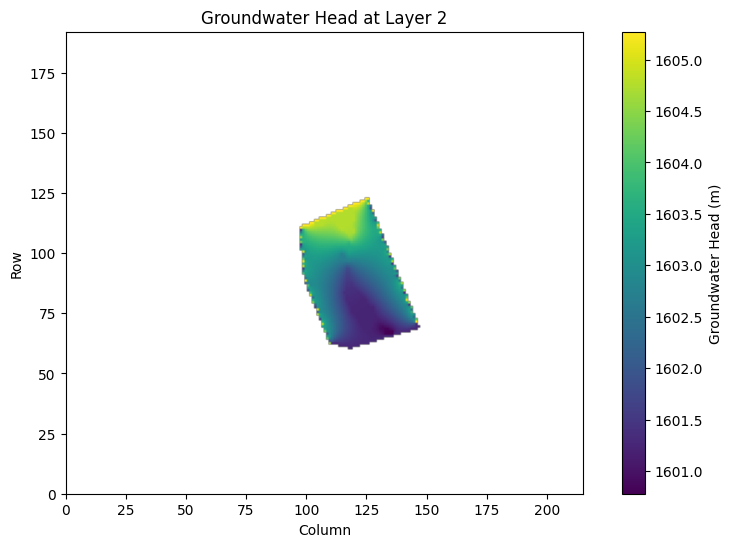

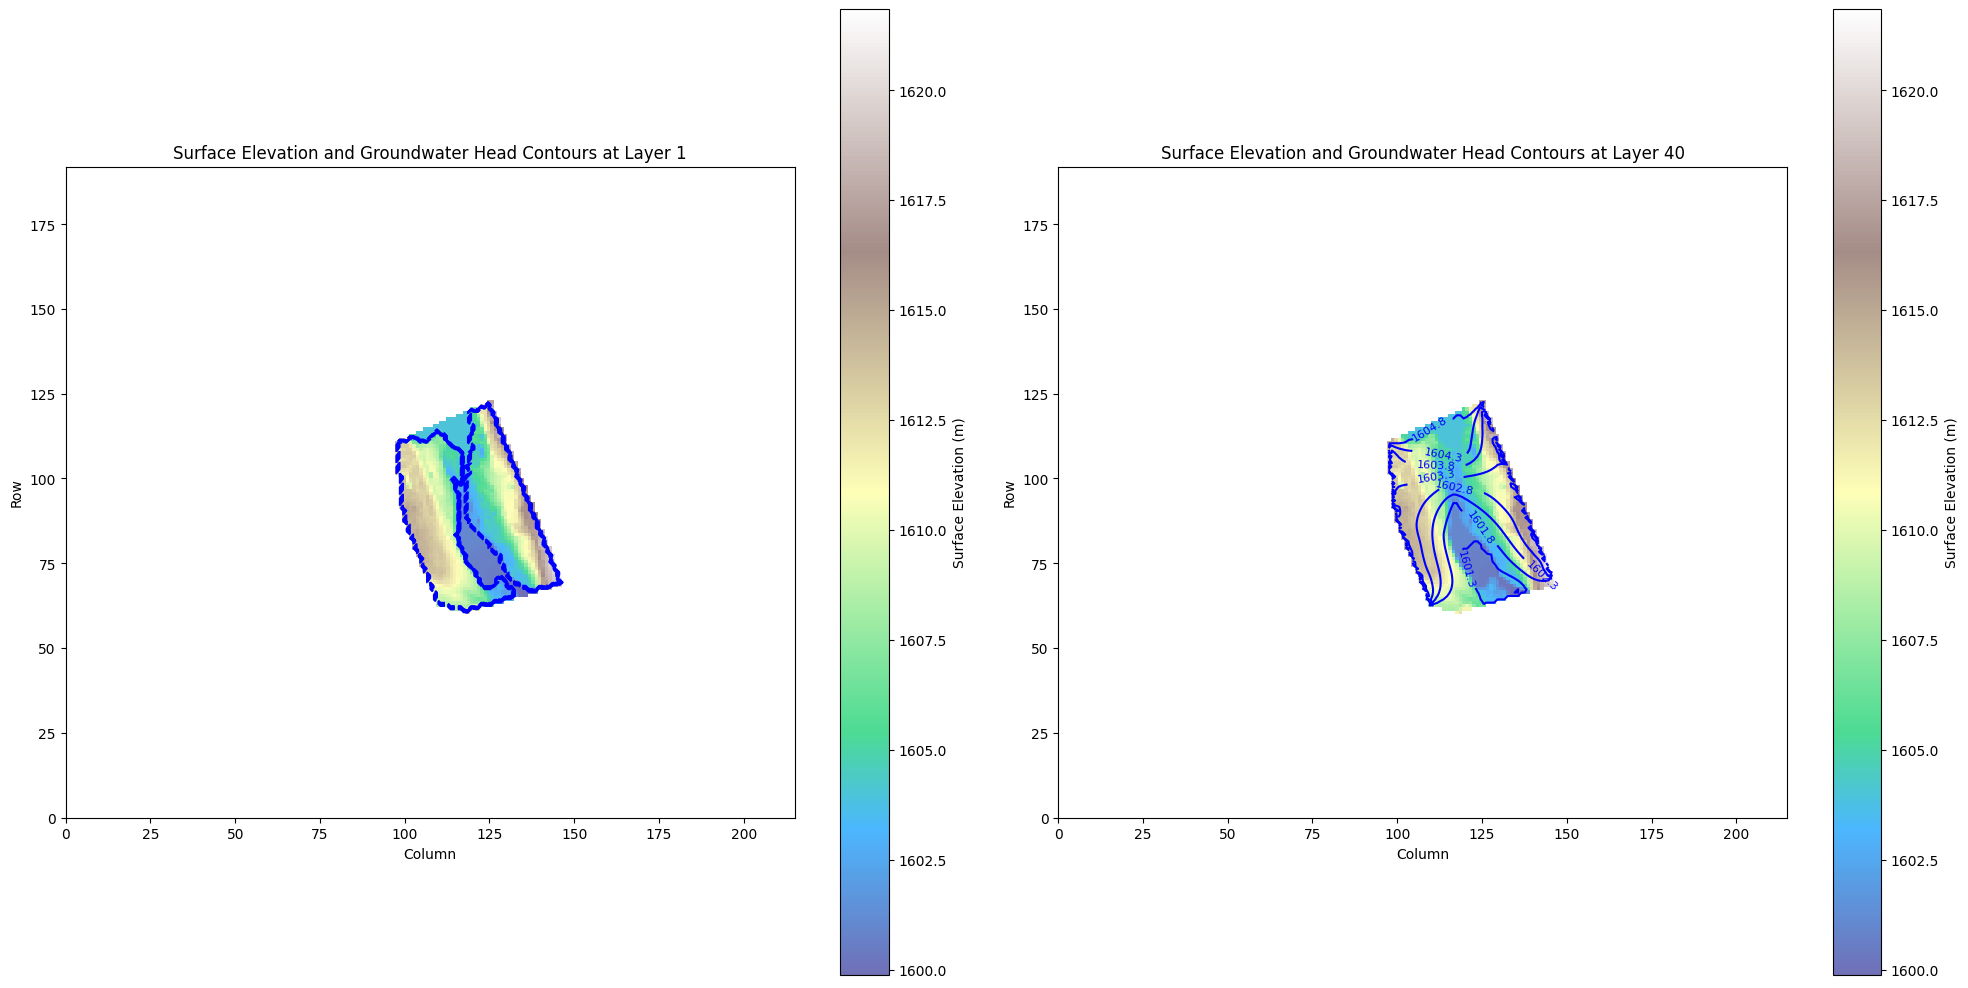

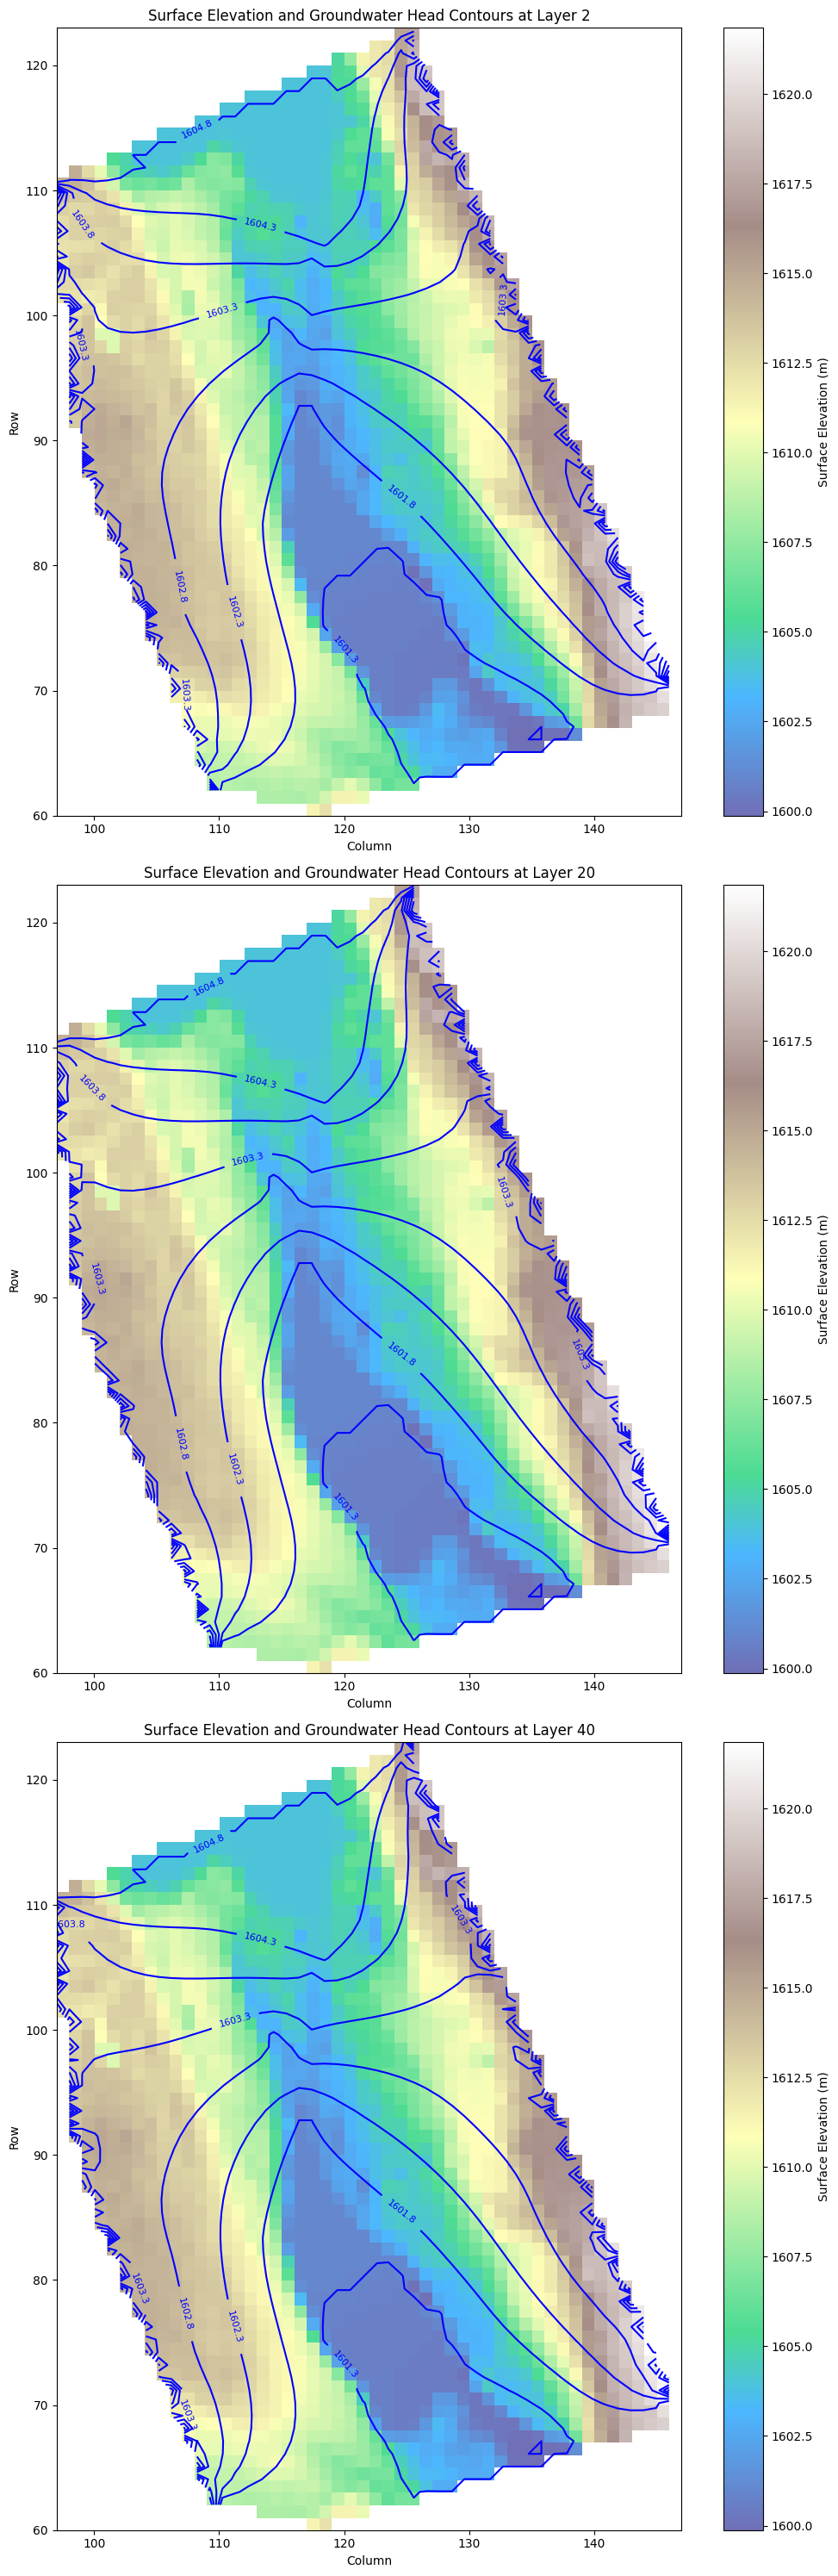

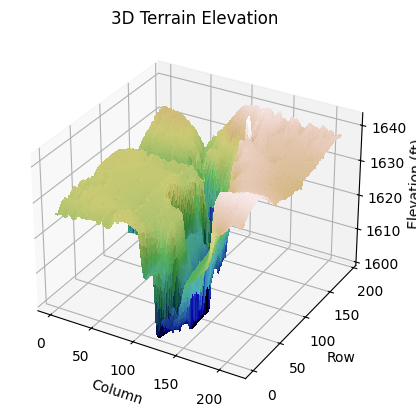

Building MODPATH 7 model for Hyporheic_Project
MODPATH 7 model built: MODPATH 7 model
MODPATH 7 files written to: HP_workspace\mp7_workspace
Running MODPATH 7...
Running model: mp7_model
Simulation mp7_model succeeded.
run_models took 485189.41 ms
FINISHED! Running MODPATH 7
Plotting MODPATH 7 Results
An error occurred while building, running, or plotting the MODPATH 7 model: plot_modpath7_results() got an unexpected keyword argument 'max_particles'


In [11]:
#---------------------- Simulation Scenario ------------------------#
def scenario(silent=False):
    """
    Orchestrates the building, running, and plotting of the MODFLOW 6 and MODPATH 7 models.

    Parameters:
    - sim_name: str, simulation name
    - gwf_name: str, groundwater flow model name
    - md6_exe_path: str, path to the MODFLOW 6 executable
    - gwf_ws: str, workspace for the GWF model
    - nper: int, number of stress periods
    - perlen: float, length of each stress period
    - nstp: int, number of time steps per stress period
    - tsmult: float, time step multiplier
    - botm: list, bottom elevations of the layers
    - nrow: int, number of rows in the grid
    - ncol: int, number of columns in the grid
    - cell_size_x: float, cell width
    - cell_size_y: float, cell height
    - tops: list, top elevations of the layers
    - idomain: list, active/inactive cell array
    - xorigin: float, x-coordinate origin
    - yorigin: float, y-coordinate origin
    - bed_elevation: float, bed elevation
    - kh: float, horizontal hydraulic conductivity
    - kv: float, vertical hydraulic conductivity
    - chd_data_converted: list, constant head boundary data
    - head_filerecord: str, head file record
    - budget_filerecord: str, budget file record
    - prt_ws: str, workspace for particle tracking
    - mp7_ws: str, workspace for MODPATH 7
    - write: bool, whether to write input files
    - run: bool, whether to run the models
    - plot: bool, whether to plot results
    - silent: bool, whether to suppress output
    """
    # Build the GWF model
    gwfsim, gwf = build_gwf_model(sim_name)
    
    # Debug print to check if the GWF model is built
    print("GWF model built:", gwfsim)
    
    if write:
        write_models(gwfsim, silent=silent)
        
        # Debug print to check if files are written
        print("GWF files written to:", gwf_ws)
    
    if run:
        # Run the MODFLOW model
        print("Running MODFLOW model...")
        run_models(gwfsim, silent=silent)
        print("FINISHED! Running GWF MODFLOW 6")
    
    if plot:
        print("Plotting Groundwater Flow Model")
        plot_gwf_all(gwfsim)
    
    # Attempt to build, run, and plot the MODPATH 7 particle tracking model
    try:
        # Build the MODPATH 7 model
        mp7 = build_particle_models(sim_name, gwf)
        
        # Debug print to check if the MODPATH 7 model is built
        print("MODPATH 7 model built:", mp7)
        
        if write:
            write_models(mp7, silent=silent)
            
            # Debug print to check if files are written
            print("MODPATH 7 files written to:", mp7_ws)
        
        if run:
            # Run the MODPATH 7 model
            print("Running MODPATH 7...")
            run_models(mp7, silent=silent)
            print("FINISHED! Running MODPATH 7")
        
        if plot:
            print("Plotting MODPATH 7 Results")
            
            # No wells or rivers, so pass None for nodes
            plot_modpath7_results(
                mpnamf=mp7_name,
                ws=str(mp7_ws),
                gwf=gwf,
                nlay=len(botm),
                max_particles=100
            )
    
    except Exception as e:
        print(f"An error occurred while building, running, or plotting the MODPATH 7 model: {e}")

# Example usage:
scenario(silent=True)